In [2]:
from typing import Dict, Callable
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

## Funções auxiliares

In [102]:
def ranking_consistency(scores: Dict[str, np.ndarray], ref_idx: int = 5) -> float:
    pairs = [
        ["dense-500m-arch1", "dense-500m-arch2"],
        ["dense-1b-arch1", "dense-1b-arch2"],
        ["dense-3b-arch1", "dense-3b-arch2"],
    ]

    scores_array = np.array([[scores[arc] for arc in pair] for pair in pairs])

    ref_scores = scores_array[:, :, ref_idx]
    ref_ranking = np.argsort(ref_scores)
    ref_ranking = np.argmax(ref_ranking, axis=1)

    tau = []

    for i in range(ref_idx + 1, scores_array.shape[2]):
        curr_scores = scores_array[:, :, i]
        curr_ranking = np.argsort(curr_scores)
        curr_ranking = np.argmax(curr_ranking, axis=1)
        tau_p = (curr_ranking == ref_ranking).mean()
        tau.append(tau_p)
    return np.mean(tau)

In [103]:
def autocorrelation(signal: np.ndarray, lag: int = 1) -> float:
    """Compute the autocorrelation at given lag."""
    n = len(signal)
    s1 = signal[lag:]
    s2 = signal[: n - lag]
    return np.corrcoef(s1, s2)[0, 1]


def spearmancorrelation(a: np.ndarray) -> float:
    x, y = np.array(range(len(a))), np.array(a)

    # Get ranks
    x_rank = np.argsort(np.argsort(x))
    y_rank = np.argsort(np.argsort(y))

    n = len(x)
    d_squared_sum = np.sum((x_rank - y_rank) ** 2)
    rho = 1 - (6 * d_squared_sum) / (n * (n**2 - 1))
    return max(rho, 0)


def signal_quality(scores: Dict[str, np.ndarray]) -> float:
    sc = []
    ac = []
    for key, value in scores.items():
        sc.append(spearmancorrelation(value))
        ac_ = [np.abs(autocorrelation(value, i)) for i in range(1, len(value) // 4)]
        ac.append(np.mean(ac_))
        break

    sc = np.mean(sc)
    ac = np.mean(ac)
    return (sc + ac) / 2

In [104]:
def agg_mean(scores : np.ndarray) -> float:
    return np.mean(scores)


In [117]:
arc_options = [
    "dense-500m-arch1",
    "dense-1b-arch1",
    "dense-3b-arch1",
    "dense-500m-arch2",
    "dense-1b-arch2",
    "dense-3b-arch2",
]


def eval_proc(post_process_fn: Callable, prompt: str, plot = False) -> Dict[str, float]:
    arc_scores = {}
    for i, arc in enumerate(arc_options):
        print(f"Processing {arc}...")
        files = sorted(
            glob(f"/hadatasets/morai/results/mmlu_sfc/{prompt}/*{arc}*/*.jsonl")
        )

        scores = []
        for file in files:
            with open(file, "r") as f:
                df = pd.read_json(f, lines=True)
                df["log_likelihoods"] = df["resps"].apply(
                    lambda resps: np.array([float(r[0][0]) for r in resps])
                )
                df["target"] = df["doc"].apply(lambda doc: int(doc["answer"]))
                df["score"] = df.apply(
                    lambda row: post_process_fn(row["log_likelihoods"], row["target"]),
                    axis=1,
                )
                score = agg_mean(df["score"].values)
                scores.append(score)
        arc_scores[arc] = scores

    print("Calculating metrics...")
    sq = signal_quality(arc_scores)
    rc = ranking_consistency(arc_scores)

    if plot:
        plt.figure(figsize=(7, 3.5))
        for arc, scores in arc_scores.items():
            plt.plot(scores, label=arc)
        plt.xlabel("Checkpoint")
        plt.ylabel("Score")
        plt.title(post_process_fn.__name__)
        plt.legend()
        plt.grid()
        plt.show()

    return {
        "signal_quality": sq,
        "ranking_consistency": rc,
        "final_score": (sq * 0.5 + rc * 0.1),
    }

## Avaliação de função de pós-processamento

Para usar, primeiro selecione uma das opções de prompt. A que funciona melhor é a "mmlu_sfc_basic". Cada uma das opções sigfinica:

- mmlu_sfc_basic: tem o enunciado no prompt, e a resposta é o texto alternativa correta
- mmlu_sfc_free: não tem nada no prompt, e a resposta é o texto alternativa correta
- mmlu_sfc_choices: tem o enunciado e todas as alternativas no prompt, e a resposta é o texto alternativa correta
- mmlu_sfc_enum: tem o enunciado e todas as alternativas no prompt, e a resposta é a letra da alternativa correta (por exemplo A)

Escolha definindo a variável `prompt`.


In [ ]:
prompt_options = [
    "mmlu_sfc_basic",
    "mmlu_sfc_free",
    "mmlu_sfc_choices",
    "mmlu_sfc_enum",
]

prompt = prompt_options[0]

Crie a sua função de avaliação. Ela deve receber como entrada um array numpy com os log-likelihoods de cada alternativa, e o índice da alternativa correta. A função deve retornar um float com a métrica de avaliação (quanto maior melhor).

No exemplo abaixo, a função retorna 1 se a alternativa com maior log-likelihood for a correta, e 0 caso contrário (acurácia). É a baseline que a competição usa.

In [107]:
def accuracy(log_likelihoods: np.ndarray, target: int) -> float:
    pred = np.argmax(log_likelihoods)
    return float(pred == target)

Para executar a avaliação, chame a função `eval_proc`, passando a sua função de avaliação e o prompt escolhido. O argumento `plot` indica se deve plotar a curva de scores médios para cada arquitetura.

(OBS: essa função deve demorar uns 2min para rodar e 2min30s se plotar os gráficos)

Processing dense-500m-arch1...
Processing dense-1b-arch1...
Processing dense-3b-arch1...
Processing dense-500m-arch2...
Processing dense-1b-arch2...
Processing dense-3b-arch2...
Calculating metrics...


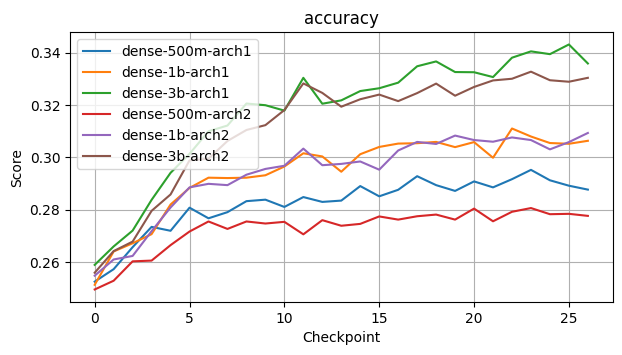

{'signal_quality': np.float64(0.890108302012292),
 'ranking_consistency': np.float64(0.8095238095238095),
 'final_score': np.float64(0.526006531958527)}

In [118]:
eval_proc(
    accuracy,
    prompt,
    plot = True
)

A solução que propomos é usar a diferença entre a log-likelihood da alternativa correta e a média das log-likelihoods das alternativas incorretas. Assim, se a diferença for grande, significa que o modelo está confiante na resposta correta, e se for pequena ou negativa, significa que o modelo está incerto ou errado.

In [110]:
def log_likelihood_diff(log_likelihoods: np.ndarray, target: int) -> float:
    correct_ll = log_likelihoods[target]
    other_lls = np.sum(log_likelihoods) - correct_ll
    mean_incorrect_ll = other_lls / (len(log_likelihoods) - 1)
    return correct_ll - mean_incorrect_ll

In [111]:
eval_proc(
    log_likelihood_diff,
    prompt,
)

Processing dense-500m-arch1...
Processing dense-1b-arch1...
Processing dense-3b-arch1...
Processing dense-500m-arch2...
Processing dense-1b-arch2...
Processing dense-3b-arch2...
Calculating metrics...


{'signal_quality': np.float64(0.9526489018694342),
 'ranking_consistency': np.float64(0.8571428571428571),
 'final_score': np.float64(0.5620387366490028)}

Algumas ideias podem ser instáveis durante o aprendizado, subindo e descendo. Por exemplo, se subtrairmos a log-likelihood máxima da mínima. Apesar de ser parecido com a solução anterior, remover o ponto fixo que é "a alternativa correta" prejudica a estabilidade.

In [112]:
def log_likelihood_diff_v2(log_likelihoods: np.ndarray, target: int) -> float:
    return np.max(log_likelihoods) - np.min(log_likelihoods)

In [113]:
eval_proc(
    log_likelihood_diff_v2,
    prompt,
)

Processing dense-500m-arch1...
Processing dense-1b-arch1...
Processing dense-3b-arch1...
Processing dense-500m-arch2...
Processing dense-1b-arch2...
Processing dense-3b-arch2...
Calculating metrics...


{'signal_quality': np.float64(0.4232335540836905),
 'ranking_consistency': np.float64(0.6666666666666666),
 'final_score': np.float64(0.27828344370851194)}